In [3]:
!pip install snscrape
!pip install text_hammer

     |████████████████████████████████| 129 kB 6.5 MB/s eta 0:00:01
     |████████████████████████████████| 115 kB 3.9 MB/s eta 0:00:01
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.11.2
    Uninstalling beautifulsoup4-4.11.2:
      Successfully uninstalled beautifulsoup4-4.11.2


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
import nltk
import text_hammer as th

nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *

import plotly.express as ps
import re
from nltk.tokenize import word_tokenize
import gensim
import string
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l1
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score 
import numpy as np
from time import time

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
df1 = pd.read_csv(r"/kaggle/input/appletwittersentimenttexts/apple-twitter-sentiment-texts.csv")
df1['sentiment'] = df1['sentiment'].map({-1: -1.0, 0: 0.0, 1:1.0})
df1.head()

text  sentiment
0  Wow. Yall needa step it up @Apple RT @heynyla:...       -1.0
1  What Happened To Apple Inc?   http://t.co/FJEX...        0.0
2  Thank u @apple I can now compile all of the pi...        1.0
3  The oddly uplifting story of the Apple co-foun...        0.0
4  @apple can i exchange my iphone for a differen...        0.0

In [6]:
df2 = pd.read_csv(r"/kaggle/input/twitterdata/finalSentimentdata2.csv",index_col=0)
df2.reset_index(drop=True, inplace=True)
df2 = df2[['text','sentiment']]
df2['sentiment'] = df2['sentiment'].map({'sad': -1.0, 'anger': -1.0, 'fear': -1.0, 'joy':1.0})
df2.head()

text  sentiment
0  agree the poor in india are treated badly thei...       -1.0
1  if only i could have spent the with this cutie...        1.0
2  will nature conservation remain a priority in ...        1.0
3  coronavirus disappearing in italy show this to...       -1.0
4  uk records lowest daily virus death toll since...       -1.0

In [7]:
#financial news
df3 = pd.read_csv(r"/kaggle/input/twitter-and-reddit-sentimental-analysis-dataset/Twitter_Data.csv")
df3 = df3.rename(columns={'clean_text':'text','category':'sentiment'})
df3.head()

text  sentiment
0  when modi promised “minimum government maximum...       -1.0
1  talk all the nonsense and continue all the dra...        0.0
2  what did just say vote for modi  welcome bjp t...        1.0
3  asking his supporters prefix chowkidar their n...        1.0
4  answer who among these the most powerful world...        1.0

In [8]:
df4 = pd.read_csv(r"/kaggle/input/twitter-airline-sentiment/Tweets.csv")
df4 = df4.rename(columns={'airline_sentiment':'sentiment'})
df4['sentiment'] = df4['sentiment'].map({'negative': -1.0, 'neutral': 0.0, 'positive':1.0})
df4 = df4[['text','sentiment']]
# Output first five rows
df4.head()

text  sentiment
0                @VirginAmerica What @dhepburn said.        0.0
1  @VirginAmerica plus you've added commercials t...        1.0
2  @VirginAmerica I didn't today... Must mean I n...        0.0
3  @VirginAmerica it's really aggressive to blast...       -1.0
4  @VirginAmerica and it's a really big bad thing...       -1.0

In [9]:
df = pd.concat([df1, df2, df3, df4], ignore_index=True)

In [10]:
df.isnull().sum()

text         4
sentiment    7
dtype: int64

In [11]:
df.dropna(axis=0,inplace=True)

In [12]:
df.shape

(182329, 2)

In [13]:
df['sentiment'] = df['sentiment'].map({-1.0:'Negative', 0.0:'Neutral', 1.0:'Positive'})
df.head()

text sentiment
0  Wow. Yall needa step it up @Apple RT @heynyla:...  Negative
1  What Happened To Apple Inc?   http://t.co/FJEX...   Neutral
2  Thank u @apple I can now compile all of the pi...  Positive
3  The oddly uplifting story of the Apple co-foun...   Neutral
4  @apple can i exchange my iphone for a differen...   Neutral

In [14]:
import plotly.express as px
px.histogram(df, x="sentiment")

In [15]:
"""
def clean(text):
    text = re.sub('[^a-zA-Z]',' ',text)
    text = text.lower()
    text = text.split(' ')
    text = [w for w in text if not w in set(stopwords.words('english'))]
    text = ' '.join(text)
    return text

df['len'] = df[''].apply(lambda x : clean(x))
df.head()"""

"\ndef clean(text):\n    text = re.sub('[^a-zA-Z]',' ',text)\n    text = text.lower()\n    text = text.split(' ')\n    text = [w for w in text if not w in set(stopwords.words('english'))]\n    text = ' '.join(text)\n    return text\n\ndf['len'] = df[''].apply(lambda x : clean(x))\ndf.head()"

In [16]:
df['len'] = [len(tweet.split()) for tweet in df['text']]
df.head()

text sentiment  len
0  Wow. Yall needa step it up @Apple RT @heynyla:...  Negative   20
1  What Happened To Apple Inc?   http://t.co/FJEX...   Neutral   10
2  Thank u @apple I can now compile all of the pi...  Positive   19
3  The oddly uplifting story of the Apple co-foun...   Neutral   17
4  @apple can i exchange my iphone for a differen...   Neutral   15

In [17]:
fig = px.box(df, y = "len", x="sentiment")
fig.show()

<AxesSubplot:title={'center':'Neutral Sentiments'}, xlabel='len', ylabel='Count'>

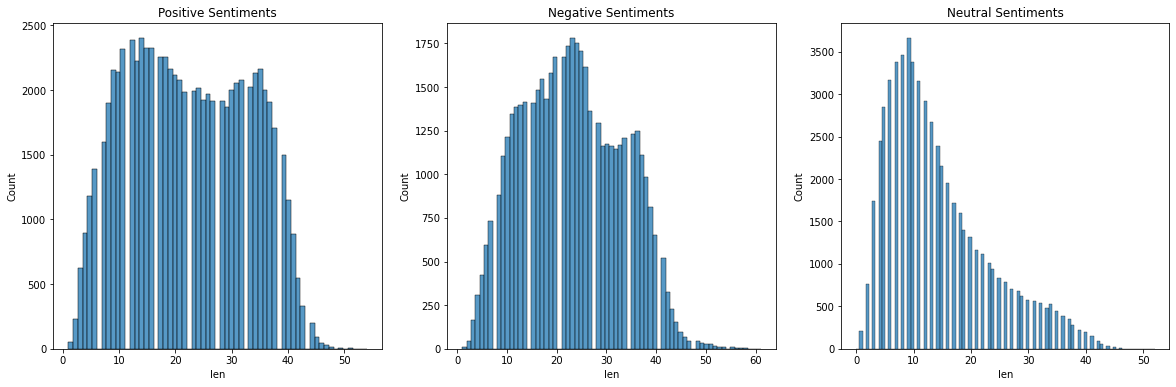

In [18]:
plt.figure(figsize=(20,6))

df_p = df[df['sentiment']=='Positive']
df_n = df[df['sentiment']=='Negative']
df_u = df[df['sentiment']=='Neutral']

plt.subplot(1, 3,1)
plt.subplot(1, 3,1).set_title('Positive Sentiments') 
sns.histplot(df_p, x="len")

plt.subplot(1,3,2)
plt.subplot(1,3,2).set_title('Negative Sentiments')                                
sns.histplot(df_n, x="len")

plt.subplot(1,3,3)
plt.subplot(1,3,3).set_title('Neutral Sentiments')                                
sns.histplot(df_u, x="len")

In [19]:
df['sentiment'].value_counts()

val = df['sentiment'].value_counts().values.tolist()
names = df['sentiment'].value_counts().index.tolist()


fig = px.pie(values=val, names=names)
fig.show()

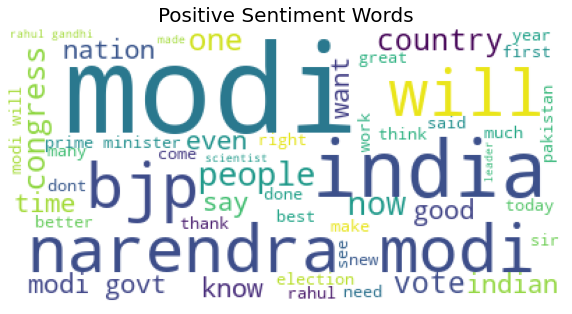

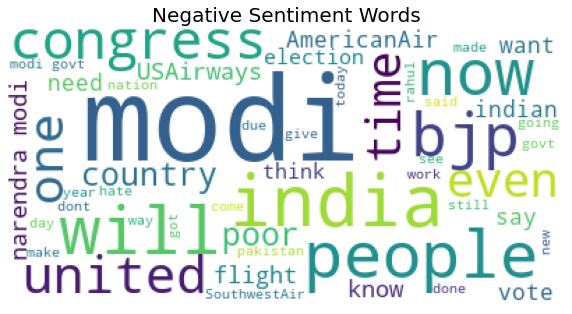

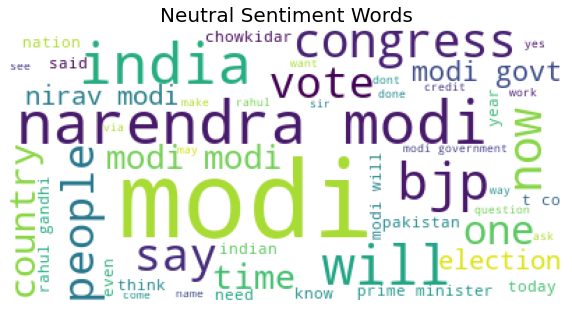

In [20]:
from wordcloud import WordCloud, STOPWORDS

def wordcloud(df,col):
    wc = WordCloud(background_color='white', 
                   max_words=50, 
                   stopwords = STOPWORDS)
    combination = " ".join([tweet for tweet in df[df['sentiment']==col]['text']])
    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(combination))
    plt.title('{} Sentiment Words'.format(col), fontsize=20)
    plt.axis('off')
    plt.show()

wordcloud(df,'Positive')
wordcloud(df,'Negative')
wordcloud(df,'Neutral')

In [24]:
df.text

0         Wow. Yall needa step it up @Apple RT @heynyla:...
1         What Happened To Apple Inc?   http://t.co/FJEX...
2         Thank u @apple I can now compile all of the pi...
3         The oddly uplifting story of the Apple co-foun...
4         @apple can i exchange my iphone for a differen...
                                ...                        
182335    @AmericanAir thank you we got on a different f...
182336    @AmericanAir leaving over 20 minutes Late Flig...
182337    @AmericanAir Please bring American Airlines to...
182338    @AmericanAir you have my money, you change my ...
182339    @AmericanAir we have 8 ppl so we need 2 know h...
Name: text, Length: 182329, dtype: object

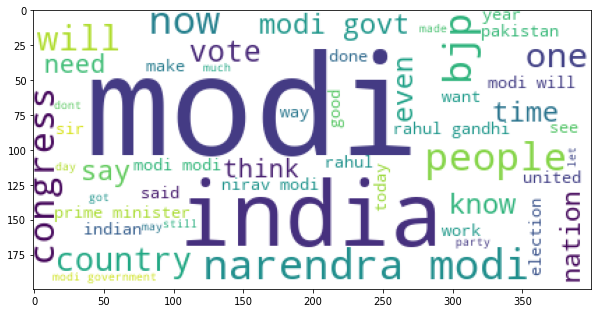

In [25]:
combined_tweets = " ".join([tweet for tweet in df.text])
                          
# Initialize wordcloud object
wc = WordCloud(background_color='white', 
                max_words=50, 
                stopwords = STOPWORDS)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(combined_tweets))

In [19]:
#

In [20]:
df_p = df_p.sample(47000)
df_u = df_u.sample(47000)
df_n = df_n.sample(47000)
df = pd.concat([df_p,df_n,df_u],axis=0)
df = df.sample(frac=1).reset_index(drop=True)
df.drop(['len'], axis = 1, inplace = True) 
df.head(2)

text sentiment
0  absolutely nothing fearful about our shri nare...  Negative
1  this the point “modi has not turned out the tr...   Neutral

In [21]:
df['sentiment'].value_counts()

Negative    47000
Neutral     47000
Positive    47000
Name: sentiment, dtype: int64

## Data Cleaning

In [22]:
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
    #df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_stopwords(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
    return(df)

df = text_preprocessing(df,'text')

  0%|          | 0/141000 [00:00<?, ?it/s]

  0%|          | 0/141000 [00:00<?, ?it/s]

  0%|          | 0/141000 [00:00<?, ?it/s]

  0%|          | 0/141000 [00:00<?, ?it/s]

  0%|          | 0/141000 [00:00<?, ?it/s]

  0%|          | 0/141000 [00:00<?, ?it/s]

# GloVe for Vectorization

Here we will use GloVe pretrained corpus model to represent our words.It is available in 3 varieties :50D ,100D and 200 Dimentional.We will try 50 D here because the Dataset is small.If you have a larger dataset,you can use 100D or 200D.

In [23]:
stop=set(stopwords.words('english'))

def create_corpus(df):
    corpus=[]
    for tweet in df['text']:
        words = [word.lower() for word in word_tokenize(tweet) if ((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

corpus = create_corpus(df)

In [24]:
flat_corpus = [word for tweet in corpus for word in tweet]

unique_words = set(flat_corpus)

print("Total number of unique words in corpus:", len(unique_words))

Total number of unique words in corpus: 92794


## Reason 101 - Why we cant use Glove for word embeddings?

The words in the corpus are a combination of hinglish words, it contains several words in the Indian context whose word embeddings cant be obtained from glove as it is A combination of the 
Wikipedia 2014 dump and the Gigaword 5 corpus, with 400,000 tokens considered unique

['chowkidar', 'americanair', 'southwestair', 'bhakts', 'bhakt', 'modiji', 'nyay', 'mumkin', 'antimodi', 'flightled', 'demonetisation', 'covid', 'virginamerica', 'chowkidars', 'bcoz', 'bjps', 'hatao', 'chowkidaar', 'antinational', 'modishah', 'abhinandan', 'feku', 'mrmodi', 'tejasvi', 'chaiwala', 'shouldnt', 'bcz', 'jumlas', 'garibi', 'antiindia', 'remonetise', 'congi', 'narender', 'congis', 'congressi', 'chokidar', 'pidis', 'tukde', 'flightr', 'rahuls', 'hahaha', 'sabka', 'modibjp', 'doval', 'oppn', 'aayog', 'ayushman', 'yojna', 'journos', 'honble', 'mnrega', 'becoz', 'itna', 'nehrus', 'malya', 'retweet', 'fakendra', 'chaukidar', 'pidi', 'surjewala', 'sanghis', 'maam', 'neerav', 'loworbit', 'orop', 'bjpmodi', 'burnol', 'tshirts', 'mahagathbandhan', 'dailyhunt', 'ambanis', 'aadhar', 'achhe', 'chutiya', 'ayog', 'acche', 'exchief', 'antinationals', 'pakoda', 'adityanath', 'abki', 'uturn', 'andh', 'chamcha', 'bahut', 'demonitisation', 'sambit', 'chahiye', 'erosnow', 'urself', 'chamchas', 'shld', 'asaduddin', 'waah', 'tejaswi', 'ofcourse', 'swachh', 'pmmodi', 'mallaya', 'bcos', 'bhakths', 'denge', 'ujjwala', 'knw', 'chors', 'chowkidari', 'tshirt', 'destinationdragons', 'jii', 'jaise', 'abhisar', 'aayega', 'damodardas', 'sarkaar', 'youve', 'mgnrega', 'scamsters', 'bhakth', 'chowkidhar', 'journo', 'aadhaar', 'jaitely', 'phx', 'guj', 'congresss', 'theyve', 'presstitutes', 'adanis', 'sakta', 'gareebi', 'mitron', 'khud', 'theprint', 'rahulji', 'soch', 'mynt', 'diamantaire', 'theyll', 'lekin', 'msme', 'goahead', 'gohpur', 'narendar', 'nsso', 'wouldve', 'berojgar', 'mukt', 'waise', 'atalji', 'sirji', 'tabhi', 'kejri', 'khangress', 'jayega', 'opindia', 'neech', 'choukidar', 'isliye']

In [25]:
def tweet_to_words(tweet):
    ''' Convert tweet text into a sequence of words '''
    
    # convert to lowercase
    text = tweet.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

print("\nOriginal tweet ->", df['text'][0])
print("\nProcessed tweet ->", tweet_to_words(df['text'][0]))


Original tweet -> absolutely fearful shri narendra modi lovable person cares bharat unlike leaders past explain lot yes thieves antibharat elements people sitting abroad fanning fumes bharat worry got

Processed tweet -> ['absolut', 'fear', 'shri', 'narendra', 'modi', 'lovabl', 'person', 'care', 'bharat', 'unlik', 'leader', 'past', 'explain', 'lot', 'ye', 'thiev', 'antibharat', 'element', 'peopl', 'sit', 'abroad', 'fan', 'fume', 'bharat', 'worri', 'got']


In [26]:
# Apply data processing to each tweet
X = list(map(tweet_to_words, df['text']))

In [27]:
from sklearn.preprocessing import LabelEncoder

# Encode target labels
le = LabelEncoder()
Y = le.fit_transform(df['sentiment'])

In [28]:
print(X[0])
print(Y[0])

['absolut', 'fear', 'shri', 'narendra', 'modi', 'lovabl', 'person', 'care', 'bharat', 'unlik', 'leader', 'past', 'explain', 'lot', 'ye', 'thiev', 'antibharat', 'element', 'peopl', 'sit', 'abroad', 'fan', 'fume', 'bharat', 'worri', 'got']
0


In [29]:
y = pd.get_dummies(df['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

vocabulary_size = 5000
count_vector = CountVectorizer(max_features=vocabulary_size,
                                preprocessor=lambda x: x,
                               tokenizer=lambda x: x) 

X_train = count_vector.fit_transform(X_train).toarray()

X_test = count_vector.transform(X_test).toarray()

In [31]:
print(count_vector.get_feature_names()[0:50])

['0', '000', '1', '10', '100', '1000', '10000', '108', '10th', '11', '111', '1145', '11th', '12', '1200', '12000', '125', '130', '140', '14000', '15', '150', '1500', '1500000', '1520', '157200000', '15l', '15lac', '15lakh', '19', '1947', '1962', '1969', '1971', '1974', '1980', '1984', '1991', '1998', '1hr', '1k', '1st', '2', '20', '200', '2000', '2002', '2004', '2007', '2008']


In [32]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    X = tokenizer.texts_to_sequences(text)
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['text'][0])
X, tokenizer = tokenize_pad_sequences(df['text'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 absolutely fearful shri narendra modi lovable person cares bharat unlike leaders past explain lot yes thieves antibharat elements people sitting abroad fanning fumes bharat worry got
After Tokenization & Padding 
 [ 859 3497  256    7    1  105 1551  193  753  117  303  998  277   78
 3063 3817    3  637 1629  193  455   61    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [33]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [34]:
y = pd.get_dummies(df['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (84600, 50) (84600, 3)
Validation Set -> (28200, 50) (28200, 3)
Test Set -> (28200, 50) (28200, 3)


In [35]:
import keras.backend as K
def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [36]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import datasets

from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import History

from keras import losses

vocab_size = 5000
embedding_size = 32
epochs=20
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

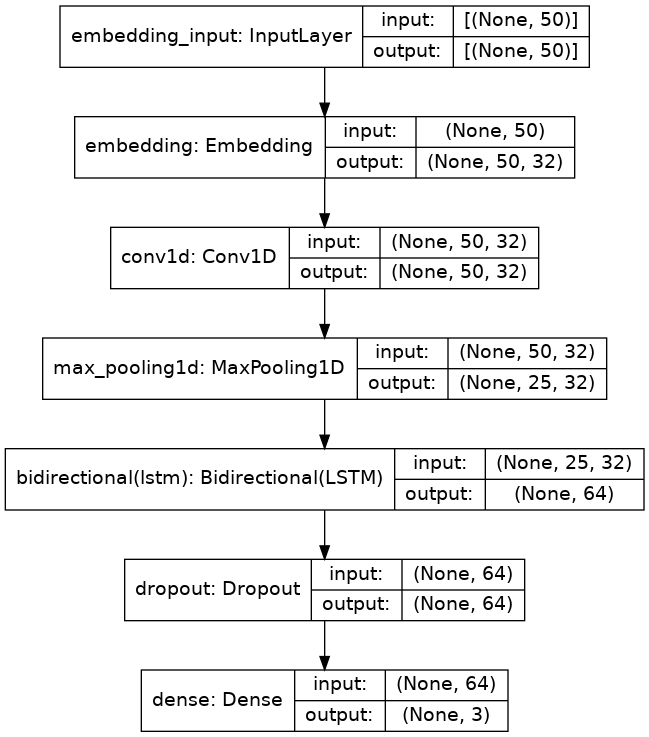

In [37]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
print(model.summary())

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=sgd, 
               metrics=['accuracy', Precision(), Recall()])

# Train model

batch_size = 64
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, verbose=1)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 32)            160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 32)            3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 25, 32)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                16640     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 195       
Total params: 179,939
Trainable params: 179,939
Non-trainable params: 0
__________________________________________________

In [ ]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))

In [ ]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)

## Model save and load for the prediction

In [ ]:
# Save the model architecture & the weights
model.save('best_model.h5')
print('Best model saved')

In [ ]:
from keras.models import load_model

# Load model
model = tf.keras.models.load_model('best_model.h5')

def predict_class(text):
    '''Function to predict sentiment class of the passed text'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    max_len=50
    
    # Transforms text to a sequence of integers using a tokenizer object
    xt = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    yt = model.predict(xt).argmax(axis=1)
    # Print the predicted sentiment
    print('The predicted sentiment is', sentiment_classes[yt[0]])

In [ ]:
predict_class(['"I hate when I have to call and wake people up'])

In [ ]:
predict_class(['The food was meh'])

In [ ]:
predict_class(['He is a best minister india ever had seen'])

## Fetching data from twitter

- To get started, you’ll need to do the following things:
- import the snscrape package

## 1. Searching for a hashtag from a specified date

Now you are ready to search Twitter for recent tweets! You will use the .Cursor method to get an object containing tweets containing the hashtag #wildfires.

To create this query, you will define the:

Search term 
- in this case #WorkFromHome
- the start date of your search

In [ ]:
# Define the search term and the date_since date as variables
from datetime import datetime


query = input("Enter query or #hashtag")
date_since = input("Enter a starting date (format: YYYY-MM-DD): ")
date_till = input("Enter a starting date (format: YYYY-MM-DD): ")

In [ ]:
!pip install --upgrade snscrape

In [ ]:
import snscrape.modules.twitter as sntwitter
print(f'{query} since:{date_since} until:{date_till}')

In [ ]:
maxTweets = 500
tweets_list2 = []

for i,tweet in enumerate(sntwitter.TwitterSearchScraper(f'{query} since:2023-01-01 until:2023-03-08').get_items()):
    if i>maxTweets:
        break
    tweets_list2.append([tweet.content])
print("Tweets of query successfully fetched !!")
tweets_df2 = pd.DataFrame(tweets_list2, columns=['Datetime', 'Tweet Id', 'Text', 'Username'])

# Display first 5 entries from dataframe
tweets_df2.head()

In [ ]:
import sys
print(sys.version)